# <center> IMDB Reviews & Amazon Reviews

## Import Libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Embedding,LSTM
from tensorflow.python.keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam
from keras.layers import Dropout
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.models import load_model
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import re
import nltk 
nltk.download("stopwords")
from nltk.corpus import stopwords
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#data = pd.read_csv("../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")

In [3]:
data = pd.read_csv("../input/amazonn-reviews/Amazon_review.csv")

In [4]:
data.head()

,Unnamed: 0,review,sentiment
0,1959029,I just adopted a chocolate lab who loves to sn...,1
1,971879,Watched it and wasn't very impressed. It was t...,0
2,44681,"By 1967, enough was enough with the light fluf...",0
3,793119,I was interested in what all the hype was abou...,0
4,2921599,I expected a well written book (as someone rec...,0


In [5]:
# we are looking at the size of our data.
data.shape

(100800, 3)

In [6]:
df = data[["review","sentiment"]]

## Exploratory Data Analysis

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100800 entries, 0 to 100799
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   review     100800 non-null  object
 1   sentiment  100800 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


- we see that there is no null value in our data. 

In [8]:
# statistical summary of our data
data.describe()

,Unnamed: 0,sentiment
count,1.008000e+05,100800.000000
mean,1.803125e+06,0.501141
std,1.040349e+06,0.500001
min,3.800000e+01,0.000000
25%,9.045188e+05,0.000000
50%,1.802794e+06,1.000000
75%,2.708176e+06,1.000000
max,3.599890e+06,1.000000


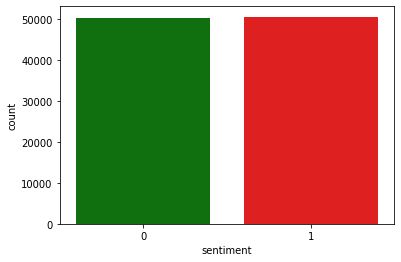

1    50515
0    50285
Name: sentiment, dtype: int64


In [9]:
sns.countplot(df["sentiment"], palette = ["green","red"])
plt.show()
print(df.sentiment.value_counts())

<ul>
    <li  style = "color:green" > <p style = "color:black;font-weight:bold" > We see that the number of positive and negative comments is equal. </p> </li>
</ul>

### Removing Stopwords

In [10]:
from nltk.corpus import stopwords
stop_word_list = stopwords.words('english')

In [11]:
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

In [12]:
tokenizer=ToktokTokenizer()

In [13]:
#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stop_word_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stop_word_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

df['clean_review']= df['review'].apply(remove_stopwords)

## Text Cleaning

- process of clearing punctuation marks in data
- cleaning unnecessary marks in data. </p> </li>
- capitalization to lowercase. </p> </li>
- cleaning extra spaces. </p> </li>
- removal of stopwords in sentences. </p> </li>


In [14]:
import re
#clearing punctuation & unnecessary marks
df['clean_review'] = df['clean_review'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))
df['clean_review'] = df['clean_review'].apply(lambda x: re.sub('[^a-zA-Z"]', ' ', x))

#capitalization to lowercase
df['clean_review'] = df['clean_review'].apply(lambda x: x.lower())

#cleaning extra spaces
df['clean_review'] = df['clean_review'].apply(lambda x: x.strip())


### Removing html strips and noise text


In [15]:
from bs4 import BeautifulSoup

In [16]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    return text

#Apply function on review column
    text = strip_html(text)
    text = remove_between_square_brackets(text)
df['clean_review']=df['clean_review'].apply(denoise_text)

## Train - Test Split 

In [17]:
df.sentiment.replace({"positive":1,"negative":0},inplace=True)

In [18]:
sentiment = df['sentiment'].values
sentiment

array([1, 0, 0, ..., 1, 0, 1])

In [19]:
data = df['clean_review']

In [20]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data,sentiment,test_size = 0.2, random_state = 42)

### Creating a Dictionary 
We create a dictionary of 15000 most used words in English for later use. 

In [21]:
from tensorflow.python.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = 15000)
tokenizer.fit_on_texts(data)

#### Bring the comments to the same size
comments of different lengths cannot train the model. That's why we need to make the sentences the same size. 

In [22]:
x_train_tokens = tokenizer.texts_to_sequences(x_train)
x_test_tokens = tokenizer.texts_to_sequences(x_test)

- We can replace the words in our sentences with whichever index they are included in the dictionary we have created above. 

In [23]:
#Then we take the word count of each of our sentences in our data and create a list.
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)

In [24]:
#Here, when setting the number of tokens, a number is determined by taking into account the variability around the average.
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

74

 max_tokens : This value will allow us to reduce the distribution of sentences in our data and the sentences with opposite lengths, if any, to the average. 

In [25]:
#It is checked what percentage of the data this determined number covers.
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.9519444444444445

In [26]:
#data is adjusted according to the number of tokens specified
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens)
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens)

In [27]:
x_train_pad.shape

(80640, 74)

# <center> Hybrid Model

In [28]:
from keras.utils.vis_utils import plot_model
from keras import layers
from keras.layers import Dense, LSTM, Bidirectional, Dropout
from keras.models import Sequential

In [29]:
embedding_size = 50
model = Sequential()
model.add(Embedding(input_dim=15000,output_dim=embedding_size,input_length=max_tokens,name='embedding_layer'))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters = 64, kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(layers.MaxPool1D(pool_size=2))
#model.add(layers.Conv1D(filters = 128, kernel_size = 9, padding = 'same', activation = 'relu'))
#model.add(layers.MaxPool1D(pool_size=2))
model.add(LSTM(units=512, return_sequences=False, dropout=0.4))
#model.add(Bidirectional(LSTM(units=64, return_sequences=False, dropout=0.4)))
model.add(Dense(64, activation="relu"))
model.add(Dense(units=1, activation='sigmoid'))
model.compile("RMSprop",loss="binary_crossentropy",metrics=["accuracy","AUC"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 74, 50)            750000    
_________________________________________________________________
batch_normalization (BatchNo (None, 74, 50)            200       
_________________________________________________________________
conv1d (Conv1D)              (None, 74, 64)            16064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 37, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 512)               1181696   
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [30]:
hybrid_history = model.fit(x_train_pad, y_train, validation_split=0.3, epochs=5, batch_size=128, shuffle=True, verbose = 1)

Epoch 1/5
441/441 [==============================] - 18s 21ms/step - loss: 0.5305 - accuracy: 0.7147 - auc: 0.7887 - val_loss: 0.4613 - val_accuracy: 0.8359 - val_auc: 0.9167
Epoch 2/5
441/441 [==============================] - 9s 20ms/step - loss: 0.2940 - accuracy: 0.8789 - auc: 0.9471 - val_loss: 0.3326 - val_accuracy: 0.8586 - val_auc: 0.9361
Epoch 3/5
441/441 [==============================] - 9s 20ms/step - loss: 0.2369 - accuracy: 0.9052 - auc: 0.9654 - val_loss: 0.3421 - val_accuracy: 0.8587 - val_auc: 0.9359
Epoch 4/5
441/441 [==============================] - 9s 20ms/step - loss: 0.1882 - accuracy: 0.9298 - auc: 0.9776 - val_loss: 0.3747 - val_accuracy: 0.8600 - val_auc: 0.9341
Epoch 5/5
441/441 [==============================] - 9s 20ms/step - loss: 0.1374 - accuracy: 0.9498 - auc: 0.9875 - val_loss: 0.4073 - val_accuracy: 0.8523 - val_auc: 0.9304


In [31]:
model.evaluate(x_test_pad,y_test)

630/630 [==============================] - 4s 5ms/step - loss: 0.4011 - accuracy: 0.8517 - auc: 0.9318


[0.4011326730251312, 0.8517361283302307, 0.931771993637085]

In [ ]:
model.evaluate(x_test_pad,y_test)

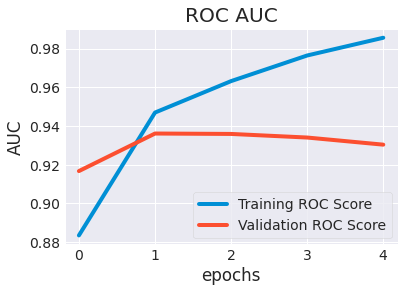

In [32]:
plt.figure()
plt.style.use("fivethirtyeight")
sns.set_style("darkgrid")
plt.plot(hybrid_history.history["auc"], label = "Training ROC Score")
plt.plot(hybrid_history.history["val_auc"], label = "Validation ROC Score")
plt.title("ROC AUC")
plt.ylabel("AUC")
plt.xlabel("epochs")
plt.legend()
plt.show()

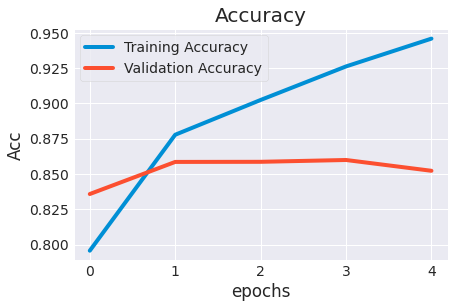

In [33]:
plt.figure()
plt.plot(hybrid_history.history["accuracy"], label = "Training Accuracy")
plt.plot(hybrid_history.history["val_accuracy"], label = "Validation Accuracy")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

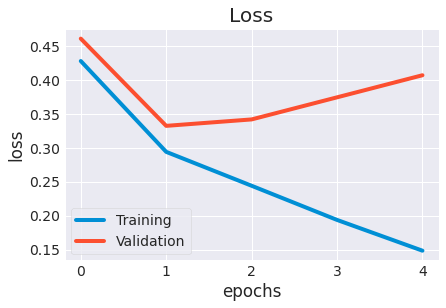

In [34]:
plt.figure()
plt.plot(hybrid_history.history["loss"], label = "Training")
plt.plot(hybrid_history.history["val_loss"], label = "Validation")
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend()
plt.show()